## Importing Necesary libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, RandomSampler, TensorDataset
import torch
from transformers import get_scheduler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import fbeta_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_fscore_support
import json
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from transformers import pipeline
import pandas as pd
from transformers import DistilBertTokenizerFast
from torch.utils.data import Dataset, DataLoader
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import DistilBertTokenizerFast, DistilBertForTokenClassification, AdamW
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
import warnings
warnings.filterwarnings('ignore')
# Setting the seed for reproducibility
torch.manual_seed(42)

# Checking if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

2024-05-12 05:28:06.979356: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 05:28:06.979414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 05:28:06.980890: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Loading the Data and analyzing the dataset structure

In [2]:
# Loading the JSON data
with open('/kaggle/input/pii-detection-removal-from-educational-data/train.json', 'r') as file:
    data = json.load(file)

# Converting to DataFrame
data = pd.json_normalize(data)
data.head()

,document,full_text,tokens,trailing_whitespace,labels
0,7,Design Thinking for innovation reflexion-Avril...,"[Design, Thinking, for, innovation, reflexion,...","[True, True, True, True, False, False, True, F...","[O, O, O, O, O, O, O, O, O, B-NAME_STUDENT, I-..."
1,10,Diego Estrada\n\nDesign Thinking Assignment\n\...,"[Diego, Estrada, \n\n, Design, Thinking, Assig...","[True, False, False, True, True, False, False,...","[B-NAME_STUDENT, I-NAME_STUDENT, O, O, O, O, O..."
2,16,Reporting process\n\nby Gilberto Gamboa\n\nCha...,"[Reporting, process, \n\n, by, Gilberto, Gambo...","[True, False, False, True, True, False, False,...","[O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT, O..."
3,20,Design Thinking for Innovation\n\nSindy Samaca...,"[Design, Thinking, for, Innovation, \n\n, Sind...","[True, True, True, False, False, True, False, ...","[O, O, O, O, O, B-NAME_STUDENT, I-NAME_STUDENT..."
4,56,Assignment: Visualization Reflection Submitt...,"[Assignment, :, , Visualization, , Reflecti...","[False, False, False, False, False, False, Fal...","[O, O, O, O, O, O, O, O, O, O, O, O, B-NAME_ST..."


In [3]:
data.isnull().sum()

document               0
full_text              0
tokens                 0
trailing_whitespace    0
labels                 0
dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6807 entries, 0 to 6806
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   document             6807 non-null   int64 
 1   full_text            6807 non-null   object
 2   tokens               6807 non-null   object
 3   trailing_whitespace  6807 non-null   object
 4   labels               6807 non-null   object
dtypes: int64(1), object(4)
memory usage: 266.0+ KB


In [5]:
# Token counts and frequency
token_counts = data['tokens'].explode().value_counts()
print(token_counts.head(20))

tokens
the     236386
        221248
.       172786
to      161026
,       152951
and     136079
of      108775
\n\n    104136
a        92086
in       66727
I        56738
that     53476
we       41533
is       41076
for      38363
with     36384
was      31822
it       28198
our      27279
on       26823
Name: count, dtype: int64


In [6]:
# Label counts and frequency
label_counts = data['labels'].explode().value_counts()
print(label_counts)

labels
O                   4989794
B-NAME_STUDENT         1365
I-NAME_STUDENT         1096
B-URL_PERSONAL          110
B-ID_NUM                 78
B-EMAIL                  39
I-STREET_ADDRESS         20
I-PHONE_NUM              15
B-USERNAME                6
B-PHONE_NUM               6
B-STREET_ADDRESS          2
I-URL_PERSONAL            1
I-ID_NUM                  1
Name: count, dtype: int64


## Exploratory Data Analysis (Visualization can help in understanding the distribution of tokens, labels, and documents.)

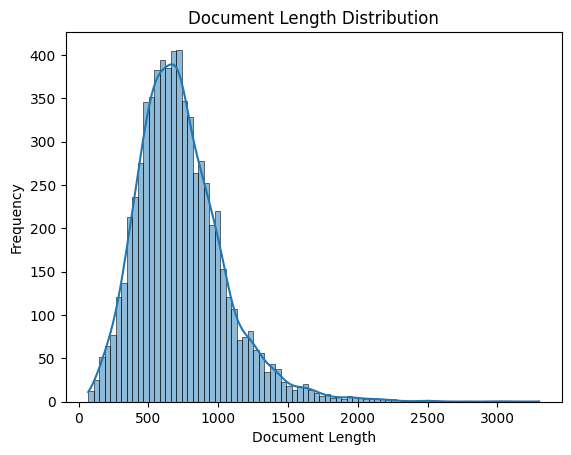

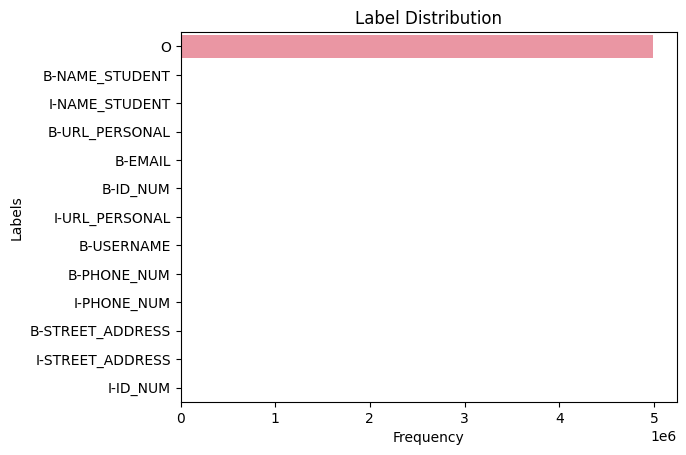

In [7]:
# Visualizing the distribution of document lengths
doc_lengths = data['tokens'].apply(len)
sns.histplot(doc_lengths, kde=True)
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

# Visualizing label distributions
sns.countplot(y=data['labels'].explode())
plt.title('Label Distribution')
plt.xlabel('Frequency')
plt.ylabel('Labels')
plt.show()

### Specific PII Analysis(Diving deeper into specific types of PII to understand their context and distribution.)

In [8]:
# Filtering the data to see examples of a specific label
pii_examples = data[data['labels'].apply(lambda x: 'B-NAME_STUDENT' in x)]
print(pii_examples.head())

# Analyzing the context around a specific PII label
def print_context(index, window=5):
    tokens = data.at[index, 'tokens']
    labels = data.at[index, 'labels']
    pii_indices = [i for i, label in enumerate(labels) if 'NAME_STUDENT' in label]
    for pii_index in pii_indices:
        start = max(0, pii_index - window)
        end = min(len(tokens), pii_index + window + 1)
        context = tokens[start:end]
        print("Context around PII:", ' '.join(context))

print_context(0) 

   document                                          full_text  \
0         7  Design Thinking for innovation reflexion-Avril...   
1        10  Diego Estrada\n\nDesign Thinking Assignment\n\...   
2        16  Reporting process\n\nby Gilberto Gamboa\n\nCha...   
3        20  Design Thinking for Innovation\n\nSindy Samaca...   
4        56  Assignment:  Visualization Reflection  Submitt...   

                                              tokens  \
0  [Design, Thinking, for, innovation, reflexion,...   
1  [Diego, Estrada, \n\n, Design, Thinking, Assig...   
2  [Reporting, process, \n\n, by, Gilberto, Gambo...   
3  [Design, Thinking, for, Innovation, \n\n, Sind...   
4  [Assignment, :,   , Visualization,  , Reflecti...   

                                 trailing_whitespace  \
0  [True, True, True, True, False, False, True, F...   
1  [True, False, False, True, True, False, False,...   
2  [True, False, False, True, True, False, False,...   
3  [True, True, True, False, False, True, 

### Explore Anomalies and Outliers(Identifying any anomalies or outliers in the data, which could affect model training)

In [9]:
# Looking for unusually long or short documents
print("Longest document length:", doc_lengths.max())
print("Shortest document length:", doc_lengths.min())

# Checking for unusual labels
unusual_labels = label_counts[label_counts < 10]  #Arbitrary threshold
print("Unusual Labels:", unusual_labels)

Longest document length: 3298
Shortest document length: 69
Unusual Labels: labels
B-USERNAME          6
B-PHONE_NUM         6
B-STREET_ADDRESS    2
I-URL_PERSONAL      1
I-ID_NUM            1
Name: count, dtype: int64


## Using DistilBert Model

### Loading both train and test josn files

In [10]:
def load_data(filename):
    return pd.read_json(filename)
    return data

# Load data
test_data = load_data('/kaggle/input/pii-detection-removal-from-educational-data/test.json')
train_data = load_data('/kaggle/input/pii-detection-removal-from-educational-data/train.json')

### Defining the label map

In [11]:
label_map = {label: i for i, label in enumerate(['O', 'B-NAME_STUDENT', 'I-NAME_STUDENT', 'B-URL_PERSONAL', 'I-URL_PERSONAL', 'B-EMAIL', 'I-EMAIL', 'B-PHONE_NUM', 'I-PHONE_NUM', 'B-ID_NUM', 'I-ID_NUM', 'B-USERNAME', 'I-USERNAME', 'B-STREET_ADDRESS', 'I-STREET_ADDRESS'])}

### Initializing the tokenizer and model

In [12]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=15)
model.to(device)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

### Preprocessing 

In [13]:
def tokenize_and_align_labels(data, tokenizer, label_map):
    tokenized_inputs = tokenizer(data['tokens'].tolist(), truncation=True, padding='max_length', is_split_into_words=True, return_tensors="pt", max_length=512)
    labels = []
    for i, label_list in enumerate(data['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Maping tokens to their word IDs
        label_ids = []
        previous_word_id = None
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)  # Special tokens receive a label of -100
            elif word_id != previous_word_id:
                label_ids.append(label_map[label_list[word_id]])  # Only label the first token of a given word
            else:
                label_ids.append(-100)  # Subsequent tokens receive a label of -100
            previous_word_id = word_id
        
        labels.append(torch.tensor(label_ids))

    tokenized_inputs['labels'] = pad_sequence(labels, batch_first=True, padding_value=-100)
    return tokenized_inputs

In [14]:
def preprocess_text(texts):
    
    # Replacing new lines and multiple spaces with a single space
    processed_texts = [text.replace('\n', ' ').replace('\r', ' ').strip() for text in texts]
    return processed_texts

In [15]:
# proceeding with tokenization and aligning labels
train_tokenized = tokenize_and_align_labels(train_data, tokenizer, label_map)

### Splitting the train dataset into train and val sets. 

In [16]:
class PIIDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

dataset = PIIDataset(train_tokenized)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

### Defining data loaders

In [17]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

### Defining optimizer and metrics

In [18]:
optimizer = AdamW(model.parameters(), lr=2e-5)

#Collecting metrics and losses for plotting
train_losses, val_losses = [], []
accuracies, f1_scores, fbeta_scores = [], [], []

### Training the model

In [19]:
def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in data_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()
    return total_loss / len(data_loader)

### Evaluting the model

In [20]:
def eval_model(model, data_loader, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            total_loss += loss.item()
            
            logits = outputs.logits.detach().cpu().numpy()
            label_ids = batch['labels'].detach().cpu().numpy()
            
            # Converting logits to predicted labels
            pred_flat = np.argmax(logits, axis=2).flatten()
            labels_flat = label_ids.flatten()
            predictions.extend(pred_flat[labels_flat != -100])  
            true_labels.extend(labels_flat[labels_flat != -100])
    
    accuracy = accuracy_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions, average='weighted')
    fbeta = fbeta_score(true_labels, predictions, beta=5, average='micro')
    
    return total_loss / len(data_loader), accuracy, f1, fbeta

### Training and Evalution loop

In [21]:
for epoch in range(10):
    train_loss = train_epoch(model, train_loader, optimizer, device)
    val_loss, accuracy, f1, fbeta = eval_model(model, val_loader, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    fbeta_scores.append(fbeta)
    
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss}, Val Loss: {val_loss}, Accuracy: {accuracy}, F1: {f1}, FBeta: {fbeta}")

Epoch 1, Train Loss: 0.05404066285069828, Val Loss: 0.004566879943013191, Accuracy: 0.9992991465516418, F1: 0.9989488426693988, FBeta: 0.9992991465516416
Epoch 2, Train Loss: 0.003575071260696593, Val Loss: 0.0025572862048351833, Accuracy: 0.9995444452585671, F1: 0.9994173114745286, FBeta: 0.999544445258567
Epoch 3, Train Loss: 0.002015795611883404, Val Loss: 0.0016544540663152327, Accuracy: 0.9997419585031044, F1: 0.9996923941398537, FBeta: 0.9997419585031043
Epoch 4, Train Loss: 0.0013267136442289, Val Loss: 0.0012833659468099562, Accuracy: 0.999786558268, F1: 0.9997355295235048, FBeta: 0.9997865582680001
Epoch 5, Train Loss: 0.0008999125643082537, Val Loss: 0.001100471030059812, Accuracy: 0.9997770011755224, F1: 0.9997246787992815, FBeta: 0.9997770011755224
Epoch 6, Train Loss: 0.0006576179333809914, Val Loss: 0.0010558151048445685, Accuracy: 0.999745144200597, F1: 0.9997190131391279, FBeta: 0.9997451442005969
Epoch 7, Train Loss: 0.0004962128045644694, Val Loss: 0.00093005819457344

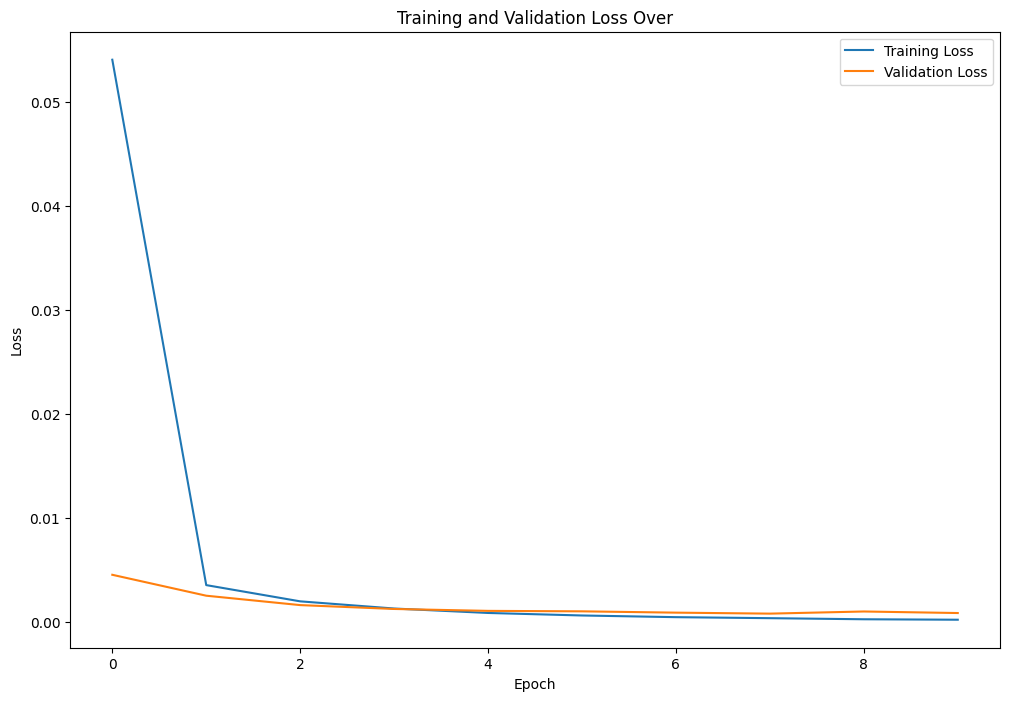

In [22]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 8))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over')
plt.legend()
plt.show()

### Saving the model

In [23]:
torch.save(model.state_dict(), '/kaggle/working/distilbert_model_weights.pth')

### Loading the saved model

In [24]:
model.load_state_dict(torch.load('/kaggle/working/distilbert_model_weights.pth'))
model.eval()  # Setting the model to evaluation mode
model.to(device)

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

### Inferencing on test data

In [25]:
# Defining the dataset for handling tokenized data
class TestData(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [26]:
def tokenize_data(data, tokenizer, max_length=512):
    tokenized_inputs = tokenizer(data['full_text'].tolist(), truncation=True, padding='max_length', is_split_into_words=False, return_tensors="pt", max_length=max_length)
    return tokenized_inputs

# Tokenizing the test data
test_tokenized = tokenize_data(test_data, tokenizer)

In [27]:
# Creating test dataset and loader
test_dataset = TestData(test_tokenized)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [28]:
# Predicting on test data
def predict_test_data(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predicted_labels = torch.argmax(logits, dim=-1)
            predictions.extend(predicted_labels.cpu().numpy())
    return predictions

# Getting predictions
test_predictions = predict_test_data(model, test_loader)

In [29]:
def prepare_submission(tokenized_data, predictions, tokenizer, label_map, documents):
    reverse_label_map = {v: k for k, v in label_map.items()}
    submission_rows = []
    row_id = 0

    # Iterate over each example
    for idx, (input_ids, preds) in enumerate(zip(tokenized_data['input_ids'], predictions)):
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        previous_label = None
        full_token = ""
        start_token_position = 0
        document_id = documents[idx]  

        for token_idx, (token, pred_label_idx) in enumerate(zip(tokens, preds)):
            if token in ['[CLS]', '[SEP]', '[PAD]']:
                continue
            if token.startswith("##"):
                full_token += token[2:]
            else:
                if previous_label != 'O' and full_token:
                    submission_rows.append({
                        'document': document_id,
                        'token': start_token_position,
                        'label': previous_label,
                        'token_str': full_token,
                        'row_id': row_id
                    })
                    row_id += 1
                full_token = token
                start_token_position = token_idx
                previous_label = reverse_label_map[pred_label_idx]
        
        if previous_label != 'O' and full_token:
            submission_rows.append({
                'document': document_id,
                'token': start_token_position,
                'label': previous_label,
                'token_str': full_token,
                'row_id': row_id
            })
            row_id += 1

    return pd.DataFrame(submission_rows)

In [30]:
submission_df = prepare_submission(test_tokenized, test_predictions, tokenizer, label_map, test_data['document'])
submission_df.to_csv('submission.csv', index=False)
submission_df

,document,token,label,token_str,row_id
0,7,12,B-NAME_STUDENT,nathalie,0
1,7,15,I-NAME_STUDENT,sylla,1
2,7,474,B-NAME_STUDENT,nathalie,2
3,7,477,I-NAME_STUDENT,sylla,3
4,10,1,B-NAME_STUDENT,diego,4
5,10,2,I-NAME_STUDENT,estrada,5
6,10,444,B-NAME_STUDENT,diego,6
7,10,445,I-NAME_STUDENT,estrada,7
8,16,4,B-NAME_STUDENT,gilberto,8
9,16,6,I-NAME_STUDENT,gamboa,9
